In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidnoiseanalysis import plot_psd
from mkidreadoutanalysis.mkidreadout import MKIDReadout
from mkidreadoutanalysis.optimal_filters.make_filters import Calculator
from mkidreadoutanalysis.optimal_filters.config import ConfigThing
import copy
%matplotlib inline

# Import Data

In [2]:
data = np.load(f'/work/jpsmith/Gen3/Fridge_Tests/r_testing/data/white_fridge/10_18_23/wf_ellison3_6000_650GHz.npz')

dark_phase=data['dark_phase']
dark_iq=data['dark_iq'] 
ir_phase=data['ir_phase']
ir_iq=data['ir_iq']
red_phase=data['red_phase']
red_iq=data['red_iq']
blue_phase=data['blue_phase']
blue_iq=data['blue_iq']

In [30]:
import os
print(os.getcwd())

/tmp/pycharm_project_42


# Raw Data

## Red Data

### FPGA Phase

#### Set Threshold and Deadtime

In [3]:
red_phase_readout = MKIDReadout()
red_phase_readout.trigger(red_phase, fs = 1e6, threshold=-0.15, deadtime=30)
print(f'Total photons: {(red_phase_readout.trig>0).sum()}')

Total photons: 22381


#### Triggered Phase Timestream

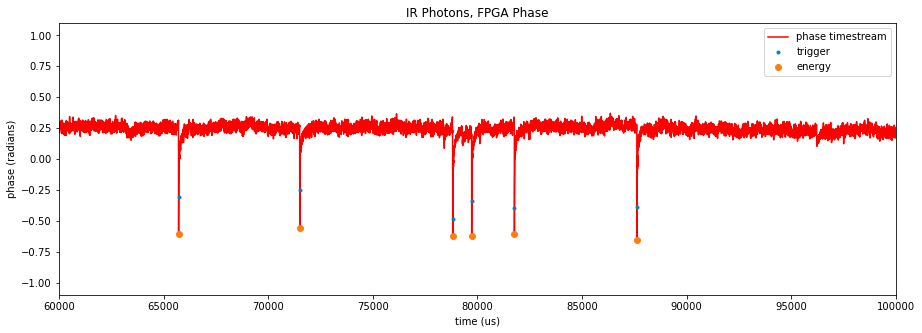

In [4]:
red_phase_readout.plot_triggers(red_phase, fs=1e6, energies=True, color='red')
plt.xlim([60000,100000]);
plt.title('Red (663.1 nm) Photons, FPGA Phase');

#### Phase Histogram

Max Phase: -0.6392868188066155 FWHM: 0.06094268945730963 radians


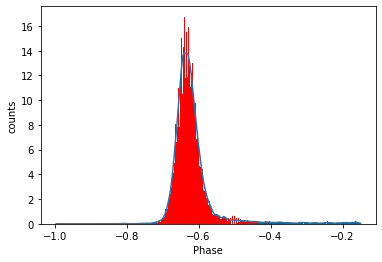

In [5]:
red_phase_max_location, red_phase_fwhm = compute_r(red_phase_readout.photon_energies, color='red', plot=True)
print(f'Max Phase: {-red_phase_max_location} FWHM: {red_phase_fwhm} radians')
plt.title('Red Photons (663.1 nm), FPGA Phase');

### FPGA IQ --> Phase

#### Set Threshold and Deadtime

In [7]:
red_iq_readout = MKIDReadout()
red_iq_phase = np.angle(red_iq)
red_iq_readout.trigger(red_iq_phase, fs = 1e6, threshold=0.25, deadtime=60)
print(f'Total photons: {(red_iq_readout.trig>0).sum()}')

Total photons: 11059


#### Triggered Phase Timestream

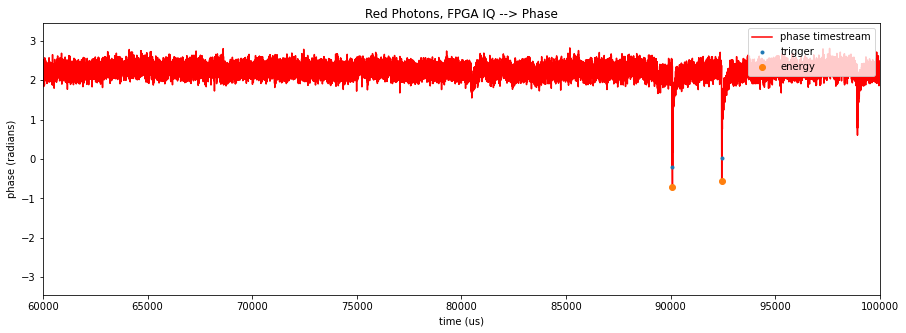

In [8]:
red_iq_readout.plot_triggers(red_iq_phase, fs=1e6, energies=True, color='red')
plt.xlim([60000,100000]);
plt.title('Red Photons (663.1 nm), FPGA IQ --> Phase');

#### Phase Histogram

Max Phase: -0.6437411910586087 FWHM: 0.28005853745603204 radians


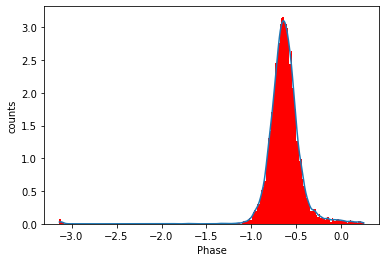

In [9]:
red_iq_max_location, red_iq_fwhm = compute_r(red_iq_readout.photon_energies, color='red', plot=True)
print(f'Max Phase: {-red_iq_max_location} FWHM: {red_iq_fwhm} radians')
plt.title('Red Photons (663.1 nm), FPGA IQ --> Phase');

## IR Data

### FPGA Phase

#### Set Threshold and Deadtime

In [10]:
ir_phase_readout = MKIDReadout()
ir_phase_readout.trigger(ir_phase, fs = 1e6, threshold=-0.15, deadtime=30)
print(f'Total photons: {(ir_phase_readout.trig>0).sum()}')

Total photons: 31178


#### Triggered Phase Timestream

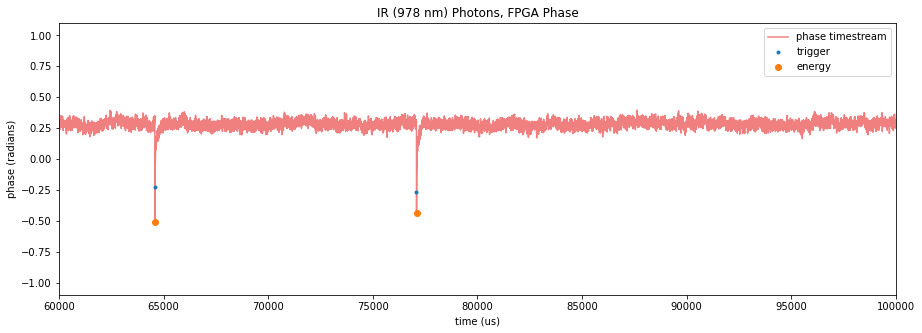

In [11]:
ir_phase_readout.plot_triggers(ir_phase, fs=1e6, energies=True, color='lightcoral')
plt.xlim([60000,100000]);
plt.title('IR (978 nm) Photons, FPGA Phase');

#### Phase Histogram

Max Phase: -0.45244148172954884 FWHM: 0.07512189441577444 radians


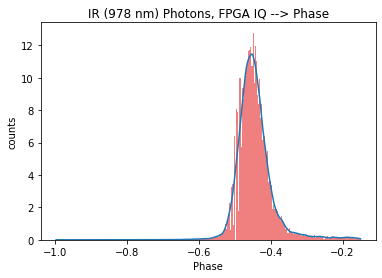

In [21]:
ir_phase_max_location, ir_phase_fwhm = compute_r(ir_phase_readout.photon_energies, color='lightcoral', plot=True)
print(f'Max Phase: {-ir_phase_max_location} FWHM: {ir_phase_fwhm} radians')
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

### FPGA IQ --> Phase

#### Set Threshold and Deadtime

In [18]:
ir_iq_readout = MKIDReadout()
ir_iq_phase = np.angle(ir_iq)
ir_iq_readout.trigger(ir_iq_phase, fs = 1e6, threshold=0.35, deadtime=60)
print(f'Total photons: {(ir_iq_readout.trig>0).sum()}')

Total photons: 15457


#### Triggered Phase Timestream

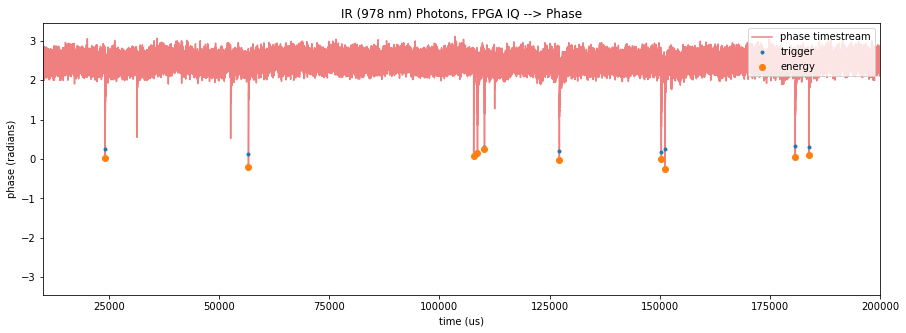

In [19]:
ir_iq_readout.plot_triggers(ir_iq_phase, fs=1e6, energies=True, color='lightcoral')
plt.xlim([10000,200000]);
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

#### Phase Histogram

Max Phase: -0.030397881199986456 FWHM: 0.3110142975006736 radians


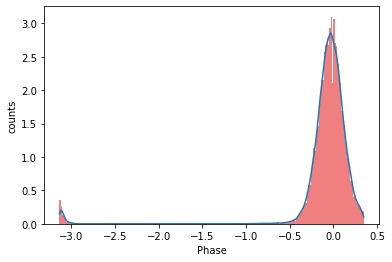

In [20]:
ir_iq_max_location, ir_iq_fwhm = compute_r(ir_iq_readout.photon_energies, color='lightcoral', plot=True)
print(f'Max Phase: {-ir_iq_max_location} FWHM: {ir_iq_fwhm} radians')
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

## Blue Data

### FPGA Phase

#### Set Threshold and Deadtime

In [24]:
blue_phase_readout = MKIDReadout()
blue_phase_readout.trigger(blue_phase, fs = 1e6, threshold=-0.25, deadtime=30)
print(f'Total photons: {(blue_phase_readout.trig>0).sum()}')

Total photons: 22271


#### Triggered Phase Timestream

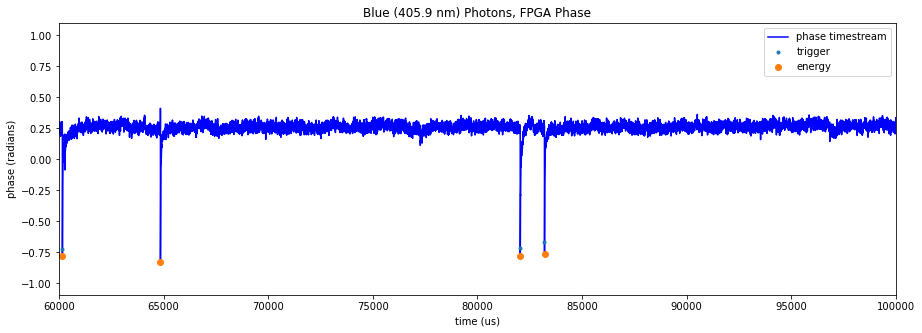

In [25]:
blue_phase_readout.plot_triggers(blue_phase, fs=1e6, energies=True, color='blue')
plt.xlim([60000,100000]);
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

#### Phase Histogram

Max Phase: -0.7836953089120626 FWHM: 0.04298288761705038 radians


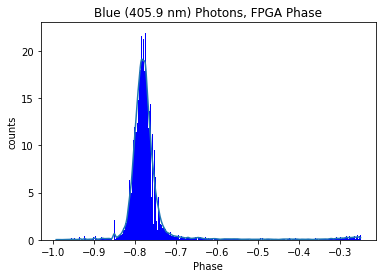

In [26]:
blue_phase_max_location, blue_phase_fwhm = compute_r(blue_phase_readout.photon_energies, color='blue', plot=True)
print(f'Max Phase: {-blue_phase_max_location} FWHM: {blue_phase_fwhm} radians')
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

### FPGA IQ --> Phase

#### Set Threshold and Deadtime

In [27]:
blue_iq_readout = MKIDReadout()
blue_iq_phase = np.angle(blue_iq)
blue_iq_readout.trigger(blue_iq_phase, fs = 1e6, threshold=0.25, deadtime=60)
print(f'Total photons: {(blue_iq_readout.trig>0).sum()}')

Total photons: 10778


#### Triggered Phase Timestream

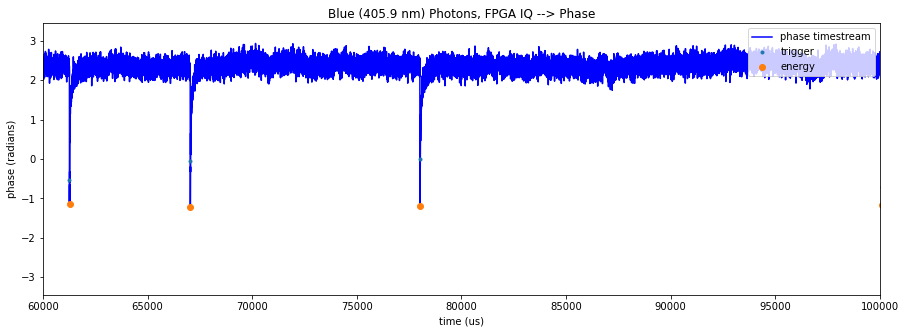

In [28]:
blue_iq_readout.plot_triggers(blue_iq_phase, fs=1e6, energies=True, color='blue')
plt.xlim([60000,100000]);
plt.title('Blue (405.9 nm) Photons, FPGA IQ --> Phase');

#### Phase Histogram

Max Phase: -1.1666672298324898 FWHM: 0.24519253434560162 radians


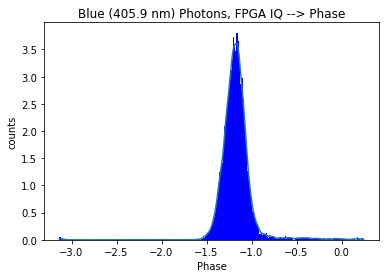

In [29]:
blue_iq_max_location, blue_iq_fwhm = compute_r(blue_iq_readout.photon_energies, color='blue', plot=True)
print(f'Max Phase: {-blue_iq_max_location} FWHM: {blue_iq_fwhm} radians')
plt.title('Blue (405.9 nm) Photons, FPGA IQ --> Phase');